# Libraries

In [1]:
import torch
from torch import nn
import torch.onnx
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import shap

from IPython.display import display, clear_output
from tqdm.notebook import tqdm

# Functions

In [2]:
class OnePathNN(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim=1, dropout_rate=0.0):
        """
        Initialize the neural network.

        Parameters:
        - input_dim: Dimension of the features.
        - hidden_dims: List of hidden layer dimensions.
        - output_dim: Dimension of the output. Defaults to 1 for a single scalar output.
        """
        super(OnePathNN, self).__init__()
        
        # Define the first path
        self.path = self._make_layers(input_dim, hidden_dims, output_dim, dropout_rate)

    def _make_layers(self, input_dim, hidden_dims, output_dim=None, dropout_rate=0.1):
        """
        Helper function to create a sequence of layers.
        """
        layers = []
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            input_dim = hidden_dim  # Update input_dim for the next layer
        if output_dim:
            layers.append(nn.Linear(hidden_dims[-1], output_dim))
        return nn.Sequential(*layers)

    def forward(self, x):
        """
        Forward pass through the network.

        Parameters:
        - x: Input.
        """
        # Pass through the combined network
        out = self.path(x)
        #return nn.ReLU(out,dim=1)
        #return torch.sigmoid(out)
        #return nn.functional.softmax(out, dim=1)
        return out

class TwoPathNN(nn.Module):
    def __init__(self, input_dim1, input_dim2, hidden_dims1, hidden_dims2, combined_hidden_dims, output_dim=1, dropout_rate=0.0):
        """
        Initialize the neural network.

        Parameters:
        - input_dim1: Dimension of the first set of features.
        - input_dim2: Dimension of the second set of features.
        - hidden_dims1: List of hidden layer dimensions for the first network.
        - hidden_dims2: List of hidden layer dimensions for the second network.
        - combined_hidden_dims: List of hidden layer dimensions for the combined network after merging the two paths.
        - output_dim: Dimension of the output. Defaults to 1 for a single scalar output.
        """
        super(TwoPathNN, self).__init__()
        
        # Define the first path
        self.path1 = self._make_layers(input_dim1, hidden_dims1)
        
        # Define the second path
        self.path2 = self._make_layers(input_dim2, hidden_dims2)
        
        # Define the combined network
        combined_input_dim = hidden_dims1[-1] + hidden_dims2[-1]  # Last layer sizes of both paths
        self.combined = self._make_layers(combined_input_dim, combined_hidden_dims, output_dim, dropout_rate)

    def _make_layers(self, input_dim, hidden_dims, output_dim=None, dropout_rate=0.1):
        """
        Helper function to create a sequence of layers.
        """
        layers = []
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            input_dim = hidden_dim  # Update input_dim for the next layer
        if output_dim:
            layers.append(nn.Linear(hidden_dims[-1], output_dim))
        return nn.Sequential(*layers)

    def forward(self, x1, x2):
        """
        Forward pass through the network.

        Parameters:
        - x1: Input for the first path.
        - x2: Input for the second path.
        """
        out1 = self.path1(x1)
        out2 = self.path2(x2)
        
        # Concatenate the outputs from both paths
        combined_out = torch.cat((out1, out2), dim=1)
        
        # Pass through the combined network
        out = self.combined(combined_out)
        #return nn.ReLU(out,dim=1)
        #return torch.sigmoid(out)
        #return nn.functional.softmax(out, dim=1)
        return out

class ModelWrapper(torch.nn.Module):
    """
    Wrapper class for a neural network model, used for SHAP analysis compatability.
    """
    def __init__(self, model, split_inputs=False):
        super().__init__()
        self.model = model
        self.split_inputs = split_inputs

    def forward(self, inputs):
        """
        Forward pass through the wrapped model.

        Parameters:
        - inputs: The input data
        - split_inputs: Split for TwoPathNN
        """
        if self.split_inputs: #TwoPathNN
            input_dim1 = self.model.path1[0].in_features
            x1 = inputs[:, :input_dim1]
            x2 = inputs[:, input_dim1:]
            return self.model(x1, x2)
        else:                 #OnePathNN
            return self.model(inputs)

def shap_analysis(model, x, features, feature_names, split_inputs= False, shap_plot_filename=None):
    """
    Perform SHAP analysis to explain the predictions.
    Parameters:
    - model: The model to analyze (compatible with SHAP's GradientExplainer)
    - x: Input data used for computing SHAP values in a format accepted by the model.
    - features: Numpy array of feature values corresponding to x
    - feature_names: List of names corresponding to the features in x
    - split_inputs: Boolean flag to indicate whether the input `x` should be split according to the model's input requirements. Defaults to False.
    - shap_plot_filename: Optional string specifying the filename to save the plot. If None, the plot is not saved.
    """

    # Initialize the model wrapper and GradientExplainer
    model_wrapper = ModelWrapper(model,split_inputs=split_inputs).eval()
    explainer = shap.GradientExplainer(model_wrapper, x)

    # Compute SHAP values
    shap_values = explainer.shap_values(x)
    shap_values = shap_values[:,:,0]

    # SHAP Summary Plot
    try:
        shap.summary_plot(shap_values, features=features, feature_names=feature_names,show=False)
        if shap_plot_filename:
            plt.savefig(shap_plot_filename,dpi=600,transparent=True)
        plt.show()
    except Exception as e:
        print("Error during SHAP plotting:", e)

    return None

def plot_losses(fig, ax, train_losses, val_losses, update_every_n_epochs, epoch, filename=None):
    """
    Update the training and validation loss plots.
    """
    if (epoch + 1) % update_every_n_epochs == 0:
        ax.clear()
        ax.plot(train_losses, label='Training Loss', color='blue')
        ax.plot(val_losses, label='Validation Loss', color='red')
        ax.set_yscale('log')
        ax.set_xlabel('Epochs',size='xx-large')
        ax.set_ylabel('Loss',size='xx-large')
        ax.tick_params(axis='x', labelsize='xx-large')
        ax.tick_params(axis='y', labelsize='xx-large')
        ax.tick_params(axis='y', which='minor', labelsize=0)
        ax.set_title('Loss Over Epochs',size='xx-large')
        ax.legend()
        if filename:
            plt.savefig(filename,dpi=600,transparent=True)
        display(fig)
        clear_output(wait=True)

    return (fig, ax)

def check_early_stopping(epoch_loss, best_loss, min_loss_change, wait, patience):
    """
    Check for early stopping.
    """
    if epoch_loss < best_loss - min_loss_change:
        best_loss = epoch_loss
        wait = 0
    else:
        wait += 1
    if wait >= patience:
        print("\nEarly stopping triggered.")
        return True, best_loss, wait
    return False, best_loss, wait

def plot_predictions_vs_actuals(actuals, predictions,mse=None,title=None,filename=None):
    """
    Plot predictions against actual values with an optional mean squared error display.
    """
    plt.figure(figsize=(8, 8))
    plt.scatter(actuals, predictions, alpha=0.5)
    plt.xlabel('Actual Values',size='xx-large')
    plt.ylabel('Predicted Values',size='xx-large')
    plt.xticks(size='xx-large')
    plt.yticks(size='xx-large')
    if title:
        plt.title(title,size='xx-large')
    else:
        plt.title('Predictions vs. Actuals',size='xx-large')
    plt.plot(np.linspace(min(actuals), max(actuals), 100), 
             np.linspace(min(actuals), max(actuals), 100), 
             color='black', linestyle='--')  # Reference line
    if mse:
        plt.text(x=0.01,y=0.9,s="MSE=%0.2f"%mse,size='xx-large')
    plt.grid(True)
    if filename:
        plt.savefig(filename,dpi=600,transparent=True)
    plt.show()

def scale_tensors(train_tensor, val_tensor):
    """Scale tensors for training and validation."""
    mean = torch.mean(train_tensor, dim=0)
    std = torch.std(train_tensor, dim=0)
    train_scaled = (train_tensor - mean) / std
    val_scaled = (val_tensor - mean) / std
    return train_scaled, val_scaled

def evaluate_model(model, data_loader):
    """
    Evaluate the model using a DataLoader and return arrays of predictions and actual values.
    """
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for batch in data_loader:
            if isinstance(model, OnePathNN):
                inputs, labels = batch
            else:  # Assuming TwoPathNN
                inputs1, inputs2, labels = batch[0], batch[1], batch[2]
                inputs = (inputs1, inputs2)
            
            if isinstance(inputs, tuple):  # For TwoPathNN
                outputs = model(*inputs)
            else:  # For OnePathNN
                outputs = model(inputs)
            
            predictions.extend(outputs.data.cpu().numpy())
            actuals.extend(labels.data.cpu().numpy())
    
    return np.array(predictions), np.array(actuals)

def train_one_epoch(model, train_loader, criterion, optimizer, device):
    """
    Train the model for one epoch.
    """
    model.train()
    running_loss = 0.0
    for batch in train_loader:
        optimizer.zero_grad()
        
        if isinstance(model, OnePathNN):
            inputs, labels = batch[0].to(device), batch[1].to(device)
            outputs = model(inputs)
        else:  # Assuming TwoPathNN
            inputs1, inputs2, labels = batch[0].to(device), batch[1].to(device), batch[2].to(device)
            outputs = model(inputs1, inputs2)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    return running_loss / len(train_loader)

def export_model_to_onnx(model, inputs, onnx_file_name):
    """
    Export a trained model to ONNX format.
    """
    model.eval()
    
    # Adjust input and output names based on the model type
    input_names = ['players', 'monsters'] if len(inputs) == 2 else ['players-monsters']
    output_names = ['HP-ratio']

    # Ensure inputs is a tuple for both model types
    inputs = (inputs,) if not isinstance(inputs, tuple) else inputs
    model_input = inputs

    # Define dynamic axes for variable batch sizes
    dynamic_axes = {name: {0: 'batch_size'} for name in input_names}
    dynamic_axes.update({output_names[0]: {0: 'batch_size'}})
    
    torch.onnx.export(model, model_input, onnx_file_name, export_params=True,
                      opset_version=11, do_constant_folding=True,
                      input_names=input_names, output_names=output_names,
                      dynamic_axes=dynamic_axes)

def validate_model(model, data_loader):
    """
    Compute the Mean Squared Error (MSE) for the model on a validation set.

    Parameters:
    - model: The PyTorch model to evaluate.
    - data_loader: DataLoader for the validation dataset.
    
    Returns:
    - mse: The Mean Squared Error of the model predictions against actual targets.
    """
    predictions, actuals = evaluate_model(model, data_loader)
    mse = mean_squared_error(actuals, predictions)
    #print(f"Mean Squared Error: {mse}")
    return mse

def train_model(model, train_loader, criterion, optimizer, num_epochs=2000, update_every_n_epochs=5, min_loss_change=1e-6, patience=20, val_split=0.2, batch_size=32,filename=None):
    """
    Train a model with the specified parameters and options, including early stopping.
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Extract dataset from the passed DataLoader
    dataset = train_loader.dataset
    train_size = int((1 - val_split) * len(dataset))
    val_size = len(dataset) - train_size
    
    # Split the dataset into new training and validation sets
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    # Create new DataLoaders for training and validation
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    train_losses = []
    val_losses = []
    wait = 0
    best_loss = np.inf

    # Initialize plotting
    fig, ax = plt.subplots(figsize=(10, 5))

    for epoch in tqdm(range(num_epochs), desc="Training Epochs"):
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss = validate_model(model, val_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        # Update plot
        fig,ax = plot_losses(fig, ax, train_losses, val_losses, update_every_n_epochs, epoch)
        
        # Check for early stopping
        early_stop, best_loss, wait = check_early_stopping(val_loss, best_loss, min_loss_change, wait, patience)
        if early_stop:
            break
        
    fig, ax = plot_losses(fig, ax, train_losses, val_losses, 1, epoch, filename=filename)
    print('Finished Training')
    return train_losses,val_losses



# Workflow

## Read data

In [3]:
filename = "./scaled_filtered_24_4_17.csv"
combat_data_df = pd.read_csv(filename)

print(combat_data_df.shape)
combat_data_df = combat_data_df[combat_data_df['party_total_hpratio']<1]
combat_data_df = combat_data_df[combat_data_df['party_total_hpratio']>0]

print(combat_data_df.shape)
print(combat_data_df.columns)
display(combat_data_df.head(1))

#Define features
x1_columns = [
    'party_size','party_total_level',
    'party_level1_spellslots', 'party_level2_spellslots',
    'party_level3_spellslots', 'party_level4_spellslots',
    'party_level5_spellslots', 'party_level6_spellslots',
    'party_level7_spellslots', 'party_level8_spellslots',
    'party_level9_spellslots', 'party_total_ac','party_total_precombat_hp',
    'party_total_prof_bonus',
    'party_total_strength', 'party_total_dexterity', 'party_total_constitution',
    'party_total_intelligence', 'party_total_wisdom', 'party_total_charisma',
    'party_max_hp','weighted_spell_slots',
    'player_monster_ratio',
    'Blood Hunter', 'Wizard', 'Fighter', 'Paladin', 'Bard',
    'Cleric', 'Warlock', 'Ranger', 'Barbarian', 'Druid', 'Monk', 'Sorcerer','Rogue'
]

x2_columns = [
    'monster_number', 'monster_total_level', 'weighted_monster_level',
    'monster_player_ratio'
]

x_columns = x1_columns+x2_columns
print(len(x1_columns),len(x2_columns),len(x_columns))

y_columns = ['party_total_hpratio']
#y_columns = ['predictor']

combat_data_df[y_columns].describe()

(10842, 63)
(5891, 63)
Index(['Unnamed: 0', 'combat_id', 'start_time', 'number_of_rounds',
       'player_ids', 'player_info', 'monsters_info', 'party_size',
       'total_slots', 'total_max_slots', 'party_classes_with_level',
       'party_total_class_composition', 'player_individual_hp_ratios',
       'player_individual_ac', 'player_individual_prof_bonus',
       'player_individual_strength', 'player_individual_dexterity',
       'player_individual_constitution', 'player_individual_intelligence',
       'player_individual_wisdom', 'player_individual_charisma',
       'monster_types', 'monster_number', 'monster_total_level',
       'party_total_level', 'party_level1_spellslots',
       'party_level2_spellslots', 'party_level3_spellslots',
       'party_level4_spellslots', 'party_level5_spellslots',
       'party_level6_spellslots', 'party_level7_spellslots',
       'party_level8_spellslots', 'party_level9_spellslots', 'party_total_ac',
       'party_total_precombat_hp', 'party_total_p

,Unnamed: 0,combat_id,start_time,number_of_rounds,player_ids,player_info,monsters_info,party_size,total_slots,total_max_slots,...,Cleric,Warlock,Ranger,Barbarian,Druid,Monk,Sorcerer,Rogue,weighted_monster_level,weighted_spell_slots
3,18,1653872787-dd8c22a6-4f2b-46f9-901a-17c887a64f29,1.653873e+09,6,"['743069156064144035', '219174602203404794']","[{'hp_ratio': (61, 81), 'class': [('Barbarian'...",[{'monster_id': 'aed32ba7-a864-41ca-a4b3-1314d...,2,"{'1': 7, '2': 3, '3': 3, '4': 3, '5': 2, '6': ...","{'1': 7, '2': 3, '3': 3, '4': 3, '5': 2, '6': ...",...,1,0,0,1,1,0,0,0,12.0,449


36 4 40


,party_total_hpratio
count,5891.000000
mean,0.703869
std,0.228804
min,0.004464
25%,0.569246
50%,0.767045
75%,0.885714
max,0.997976


## Prepare data

In [4]:
batch_size=32
# Splitting the data
X_train, X_test = train_test_split(combat_data_df, train_size=0.8, random_state=0)

# Splitting into features and labels
x1_train = X_train[x1_columns].values
x2_train = X_train[x2_columns].values
x_train = X_train[x_columns].values
y_train = X_train[y_columns].values

x1_test = X_test[x1_columns].values
x2_test = X_test[x2_columns].values
x_test = X_test[x_columns].values
y_test = X_test[y_columns].values

# Scaling
x1_train, x1_test = scale_tensors(torch.tensor(x1_train, dtype=torch.float), torch.tensor(x1_test, dtype=torch.float))
x2_train, x2_test = scale_tensors(torch.tensor(x2_train, dtype=torch.float), torch.tensor(x2_test, dtype=torch.float))
x_train, x_test = scale_tensors(torch.tensor(x_train, dtype=torch.float), torch.tensor(x_test, dtype=torch.float))
y_train, y_test = torch.tensor(y_train, dtype=torch.float), torch.tensor(y_test, dtype=torch.float)


## Two model training

### Date preparation

In [5]:
# DataLoader for the training and validation data
train_dataset = TensorDataset(x1_train, x2_train, y_train)
test_dataset = TensorDataset(x1_test, x2_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

### Model preparation

In [6]:
input_dim1 = len(x1_columns)
input_dim2 = len(x2_columns)
hidden_dims1 = [40, 80, 80, 40]  
hidden_dims2 = [40, 80, 80, 40]  
combined_hidden_dims = [80, 40, 20]

model_params = {
    'input_dim1': input_dim1,
    'input_dim2': input_dim2,
    'hidden_dims1': hidden_dims1,
    'hidden_dims2': hidden_dims2,
    'combined_hidden_dims': combined_hidden_dims,
}
                 
model = TwoPathNN(**model_params)
output = model(x1_train, x2_train)
print(output.shape)

# ONNX model
onnx_file_name = 'two_path_nn.onnx'
export_model_to_onnx(model, (x1_train, x2_train), onnx_file_name)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
torch.Size([4712, 1])


### Train model

Finished Training


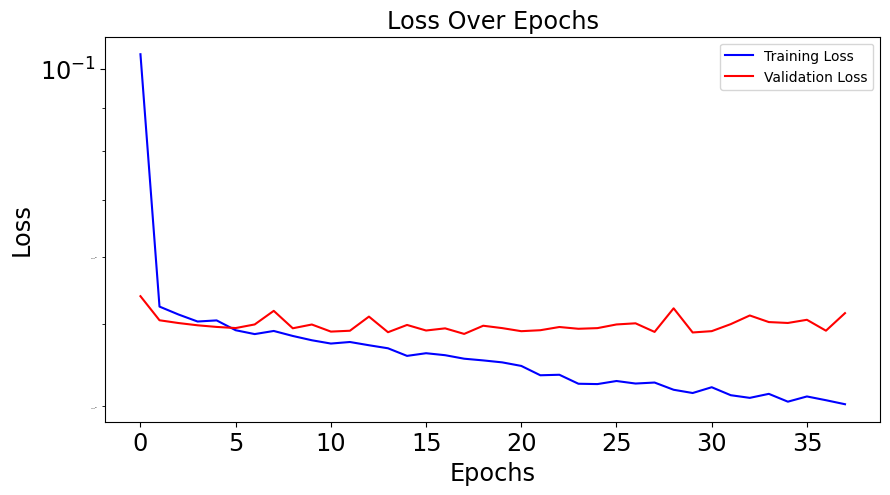

In [7]:
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005)
train_losses,val_losses = train_model(model, train_loader, criterion, optimizer ,filename='1NNepochs.png')
export_model_to_onnx(model, (x1_train, x2_train), onnx_file_name)

### Evaluate model

Mean Squared Error: 0.0407726913690567


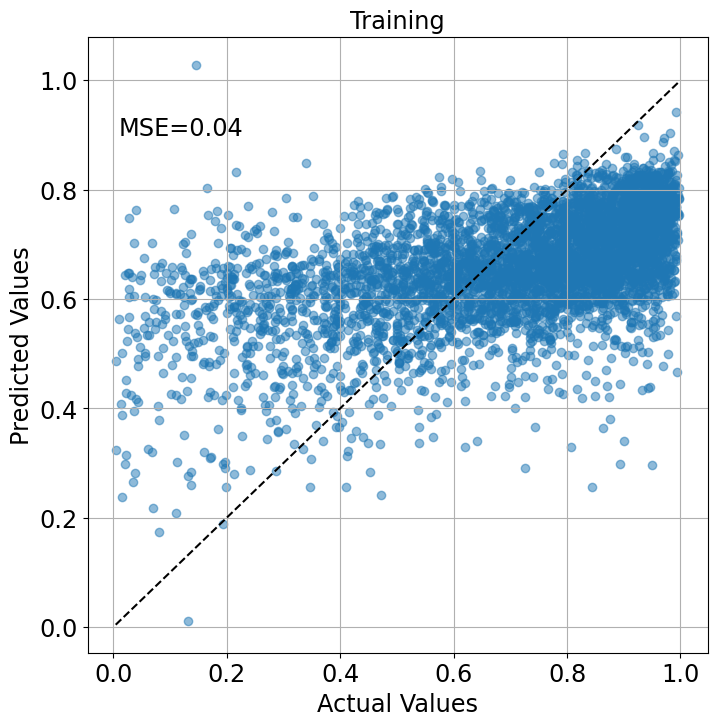

Mean Squared Error: 0.04963156580924988


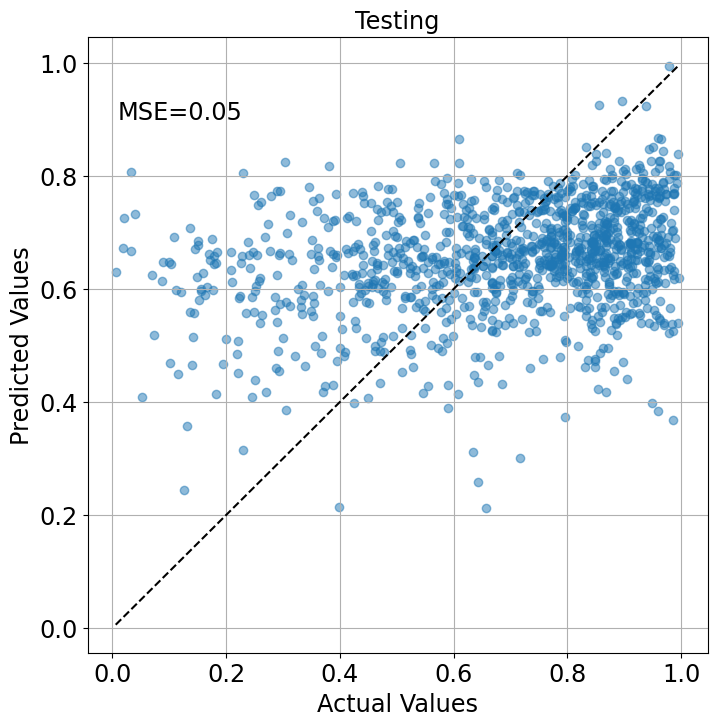

In [8]:
predictions_train, actuals_train = evaluate_model(model, train_loader)
mse = mean_squared_error(actuals_train, predictions_train)
print(f"Mean Squared Error: {mse}")
plot_predictions_vs_actuals(actuals_train, predictions_train,mse=mse,title="Training",filename='2NNtrain.png')
############################################################
predictions_test, actuals_test = evaluate_model(model, test_loader)
mse = mean_squared_error(actuals_test, predictions_test)
print(f"Mean Squared Error: {mse}")
plot_predictions_vs_actuals(actuals_test, predictions_test,mse=mse,title="Testing",filename='2NNtest.png')

# SHAP analysis

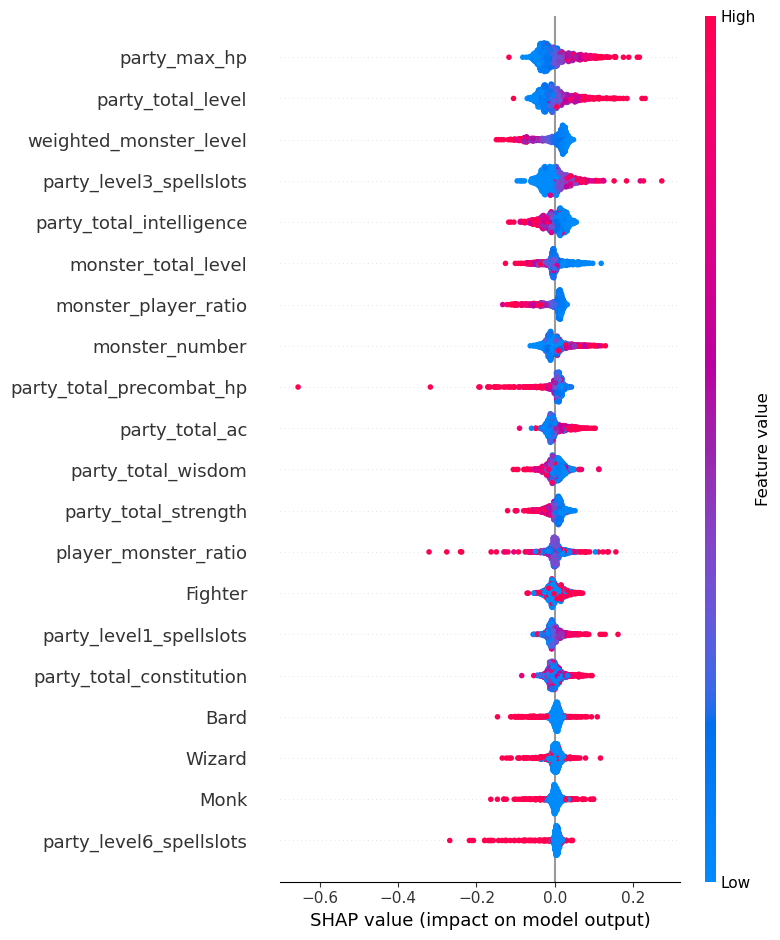

In [9]:
# Preparing data
x_shap = torch.cat((x1_train[:1000], x2_train[:1000]), dim=1)
features = x_shap.numpy()
feature_names = x1_columns + x2_columns
shap_plot_filename='2NNSHAP.png'

shap_analysis(model=model,x=x_shap, split_inputs= True, features=features,feature_names=feature_names,shap_plot_filename=shap_plot_filename)

## One NN Model

### Data Preparation

In [10]:
# DataLoader for the training and validation data
train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

### Model Preparation

In [11]:
input_dim = len(x_columns)
hidden_dims = [20, 40, 80, 80, 40, 20]
model_params = {
    'input_dim': input_dim,
    'hidden_dims': hidden_dims,
}
                 
model = OnePathNN(**model_params)
output = model(x_train)
print(output.shape)

# ONNX model
onnx_file_name = 'one_path_nn.onnx'
export_model_to_onnx(model, x_train, onnx_file_name)

torch.Size([4712, 1])


### Model training

Finished Training


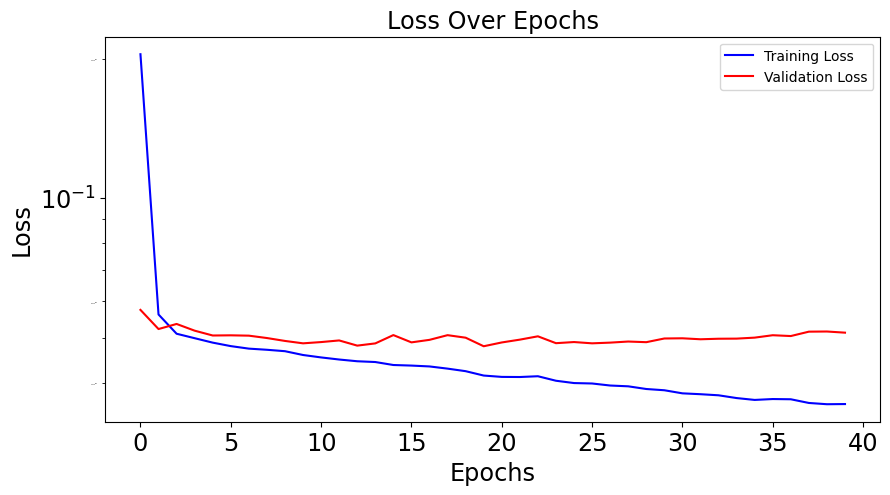

In [12]:
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005)
losses = train_model(model, train_loader, criterion, optimizer, filename='1NNepochs.png')
export_model_to_onnx(model, x_train, onnx_file_name)

### Model evaluation

Mean Squared Error: 0.03766472265124321


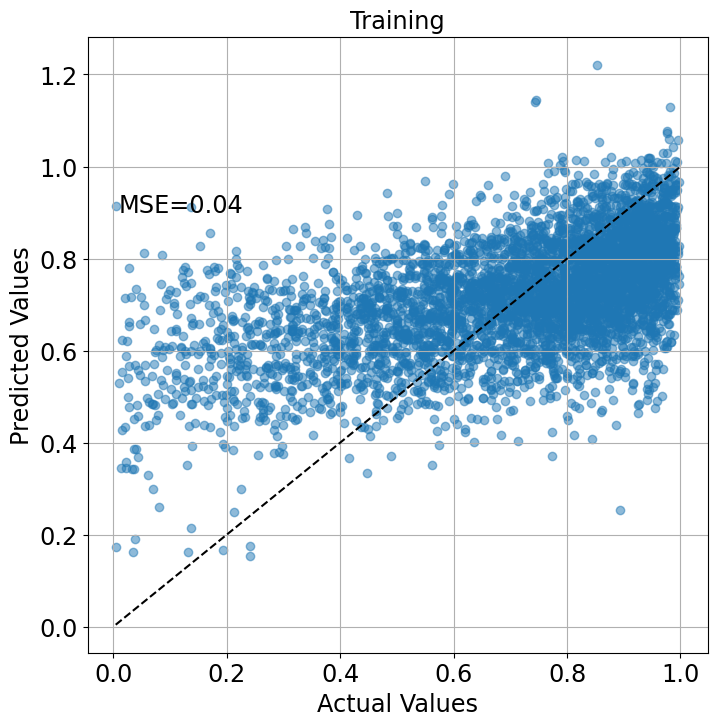

Mean Squared Error: 0.05178948864340782


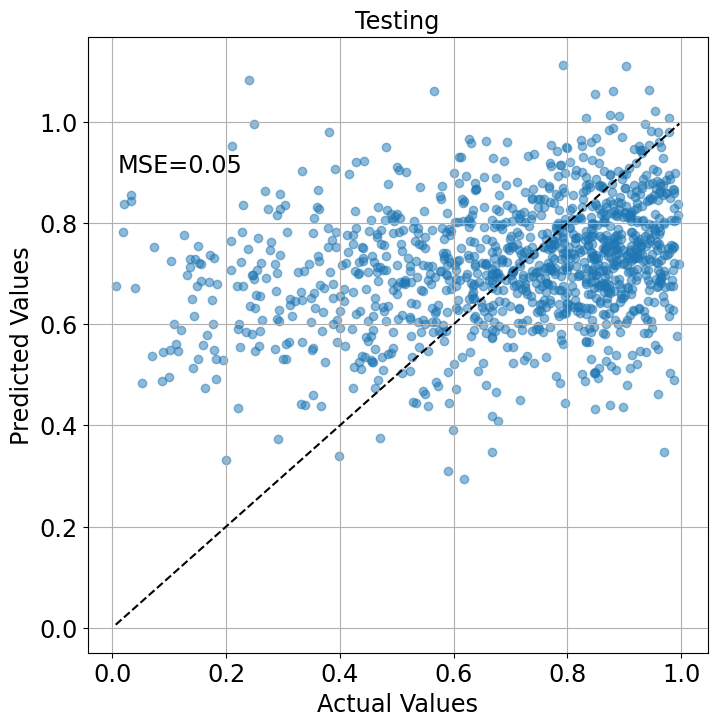

In [13]:
predictions_train, actuals_train = evaluate_model(model, train_loader)
mse = mean_squared_error(actuals_train, predictions_train)
print(f"Mean Squared Error: {mse}")
plot_predictions_vs_actuals(actuals_train, predictions_train,mse=mse,title="Training",filename='1NNtrain.png')
############################################################
predictions_test, actuals_test = evaluate_model(model, test_loader)
mse = mean_squared_error(actuals_test, predictions_test)
print(f"Mean Squared Error: {mse}")
plot_predictions_vs_actuals(actuals_test, predictions_test,mse=mse,title="Testing",filename='1NNtest.png')

### SHAP Analysis

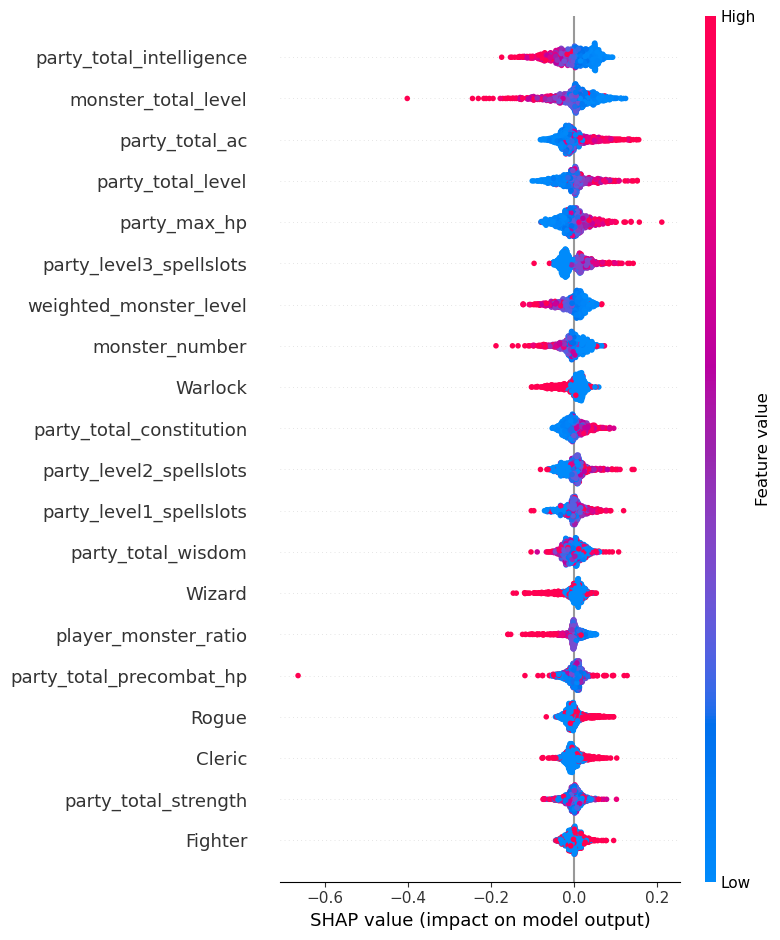

In [14]:
# Preparing data
x_shap = x_train[:1000]
features = x_shap.numpy()
feature_names = x_columns
shap_plot_filename='1NNSHAP.png'

shap_analysis(model=model,x=x_shap, split_inputs= False, features=features,feature_names=feature_names,shap_plot_filename=shap_plot_filename)
